# Lotus w/ Image Support Demo
This demo notebook demonstrates the working image support in Lotus, for both LLM calls and semantic indexing operations. This demo uses a small dataset of 151 images of different animals, as well as the name of the animal species.

In [32]:
# import dependencies
import os
import random
import pandas as pd
import json
import lotus
from lotus.models import OpenAIModel, CLIPModelRetriever
from IPython.display import Image, display
from IPython.core.display import HTML

In [33]:
# define some helper functions

def get_random_image_per_folder(directory, translation_file, seed=None):
    # Load the translation JSON file
    with open(translation_file, 'r') as f:
        translations = json.load(f)

    data = []
    visited_folders = set()

    # Iterate over each item in the given directory
    for root, dirs, files in os.walk(directory):
        # Get the parent folder name
        folder_name = os.path.basename(root)
        
        # Create a unique key for the folder using its full path
        folder_key = os.path.normpath(root)
        
        # Skip the folder if it's already been visited
        if folder_key in visited_folders:
            continue

        # Check if there are any image files in the current directory
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        
        if image_files:
            # Re-seed for each folder using a combination of the seed and folder_key
            if seed is not None:
                combined_seed = hash((seed, folder_key))
                random.seed(combined_seed)
            
            # Select a random image file
            random_image = random.choice(image_files)
            
            # Translate the folder name using the translations dictionary
            translated_name = translations.get(folder_name, folder_name)  # Default to folder_name if no translation
            
            # Construct the full path of the image
            image_path = os.path.join(root, random_image)
            
            # Append the original name, translated name, and image path to the data list
            data.append({'Name': folder_name, 'TranslatedName': translated_name, 'ImagePath': image_path})
            
            # Mark the folder as visited using its unique key
            visited_folders.add(folder_key)

    # Create a DataFrame from the collected data
    df_images = pd.DataFrame(data, columns=['Name', 'TranslatedName', 'ImagePath'])
    
    # Remove duplicate rows
    df_images.drop_duplicates(inplace=True)
    
    return df_images

def create_species_dataframe(translation_file):
    # Load the translation JSON file
    with open(translation_file, 'r') as f:
        translations = json.load(f)

    # Extract translated species names
    species_list = list(translations.values())

    # Create a DataFrame with a single column 'species'
    df_species = pd.DataFrame(species_list, columns=['species'])

    return df_species

# Function to display images from the DataFrame
def display_images_with_info(df, name_column, text_column=None):
    for index, row in df.iterrows():
        display(HTML(f"<h3>{row[name_column]}</h3>"))
        display(Image(filename=row['ImagePath']))
        
        # Display text only if text_column is specified
        if text_column:
            display(HTML(f"<p>{row[text_column]}</p>"))

In [34]:
# load the dataframes

directory_path = 'animal_images/dataset'
translation_file = 'animal_images/translation.json'
seed_value = None  # change this to any integer to get different results
df_images = get_random_image_per_folder(directory_path, translation_file, seed=seed_value)
df_species = create_species_dataframe(translation_file)

# Display the DataFrames
# print("Images DataFrame:")
# print(df_images)
# print("\nSpecies DataFrame:")
# print(df_species)

In [ ]:
# set up lotus
lm = OpenAIModel(api_key="PUT API KEY HERE")
rm = CLIPModelRetriever()
lotus.settings.configure(lm=lm, rm=rm)

c:\Users\lmelo\.conda\envs\lotus\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Lotus Operations
The cells in this section are some different lotus operations that can be performed on the animal images dataset

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Accuracy: 86.09%


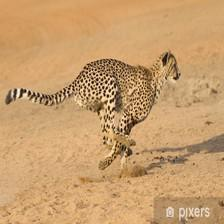

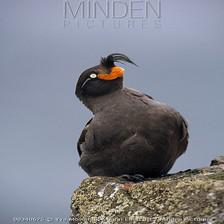

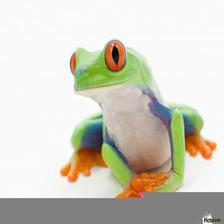

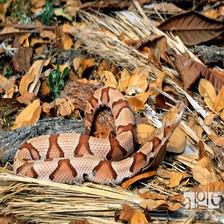

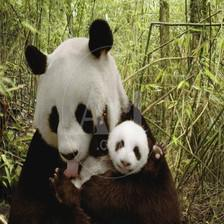

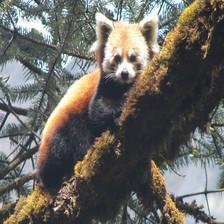

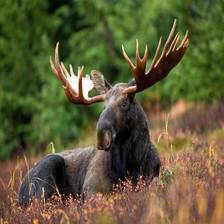

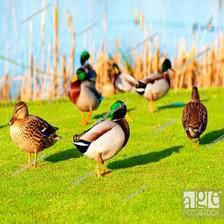

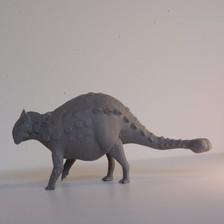

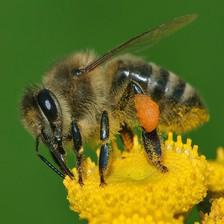

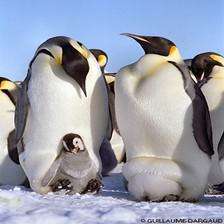

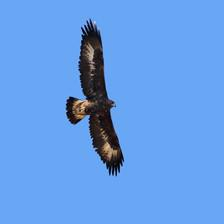

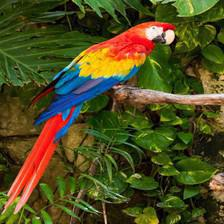

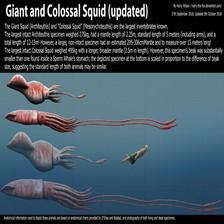

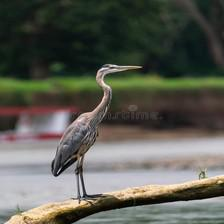

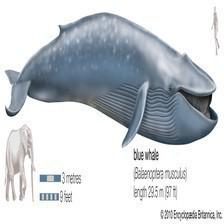

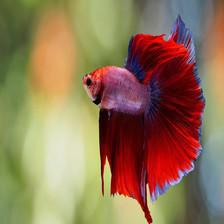

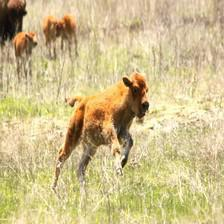

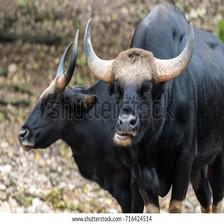

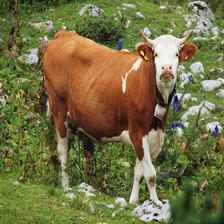

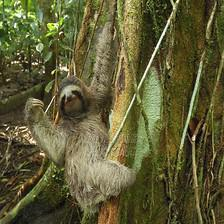

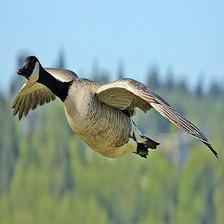

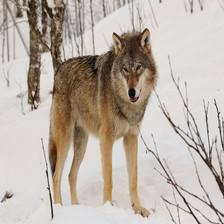

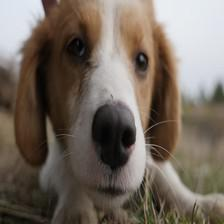

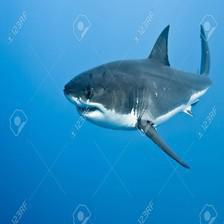

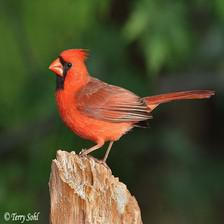

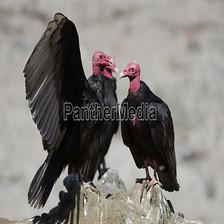

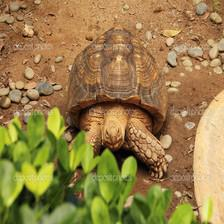

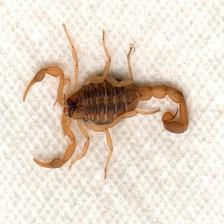

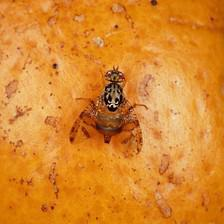

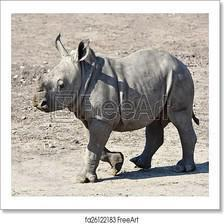

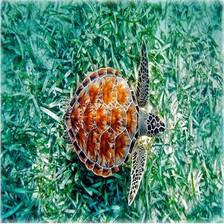

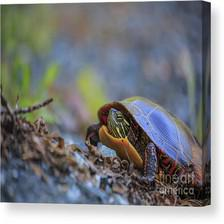

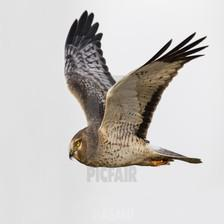

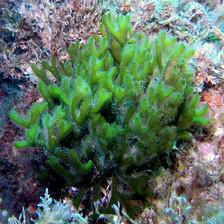

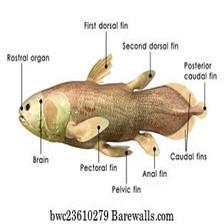

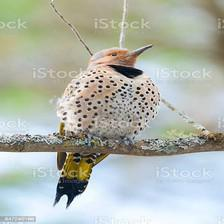

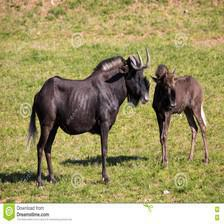

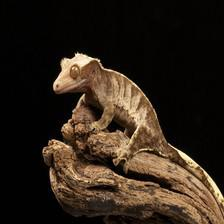

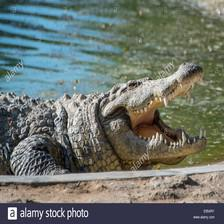

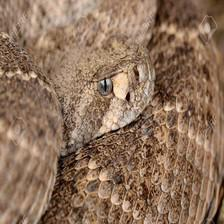

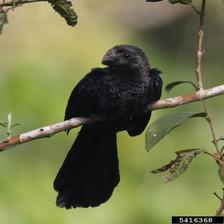

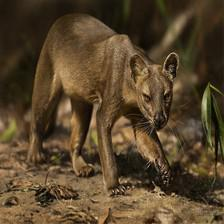

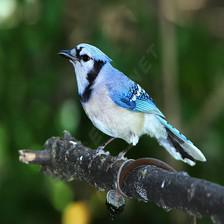

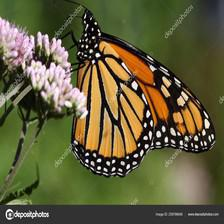

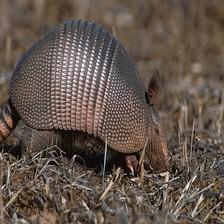

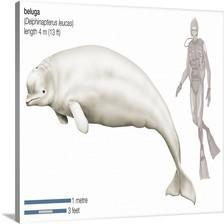

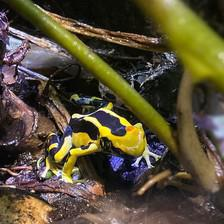

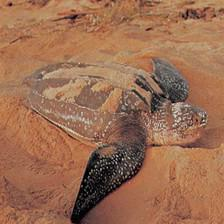

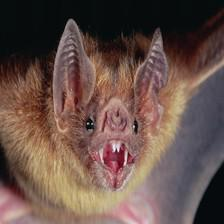

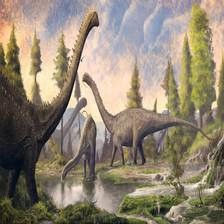

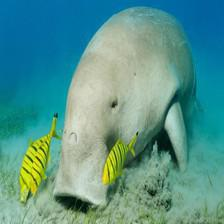

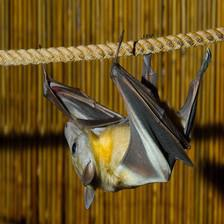

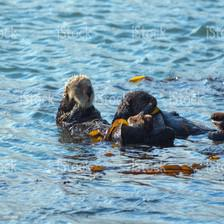

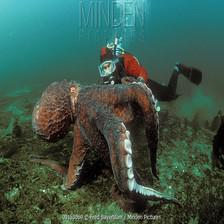

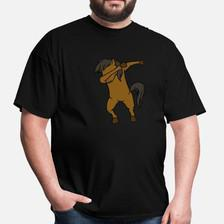

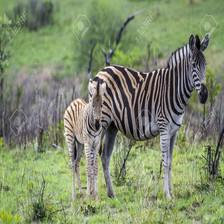

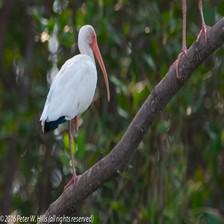

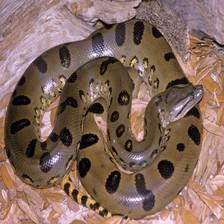

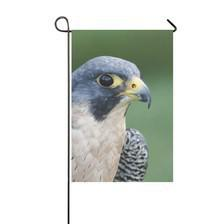

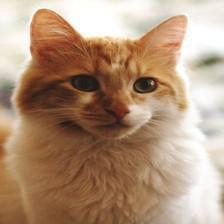

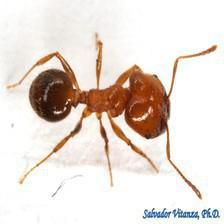

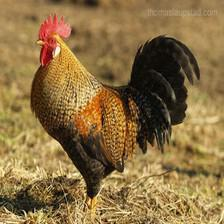

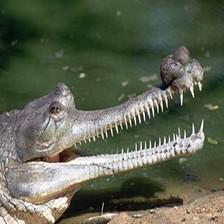

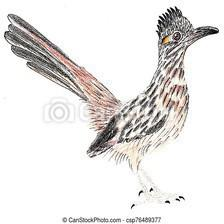

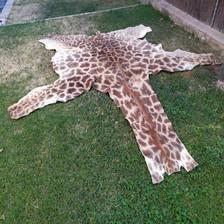

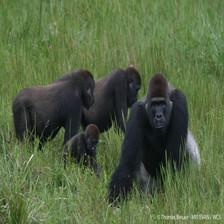

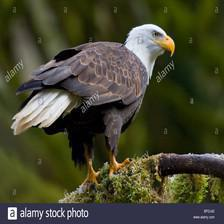

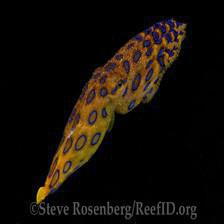

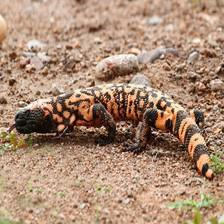

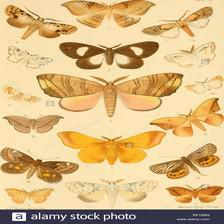

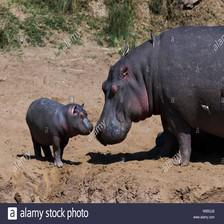

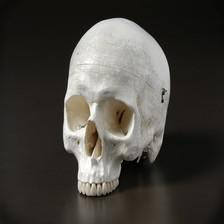

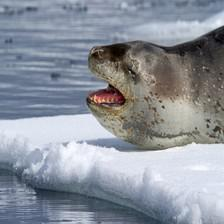

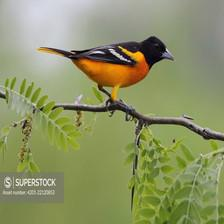

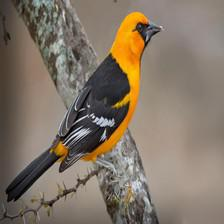

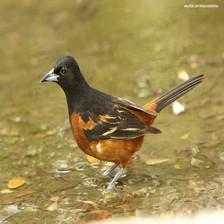

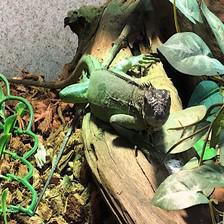

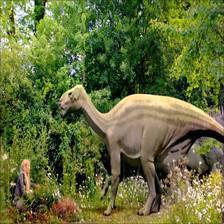

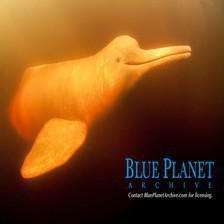

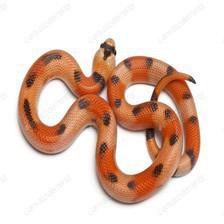

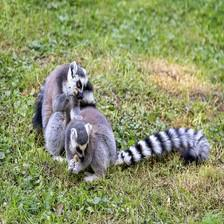

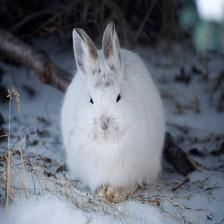

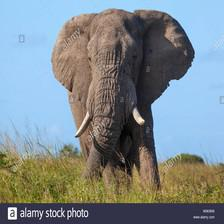

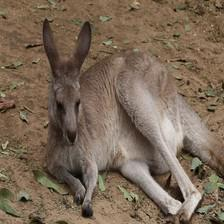

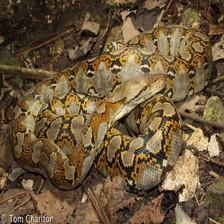

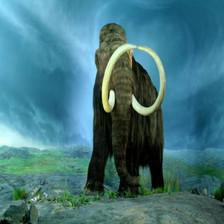

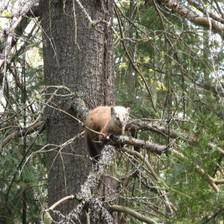

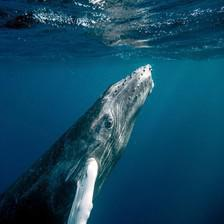

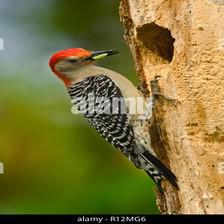

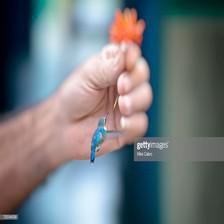

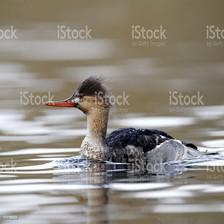

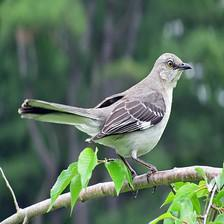

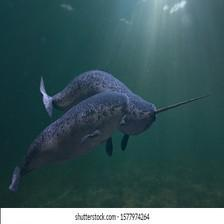

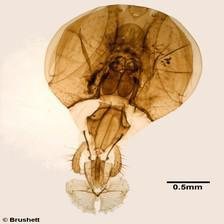

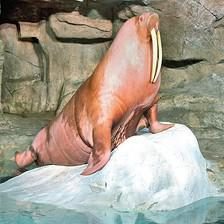

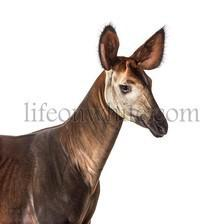

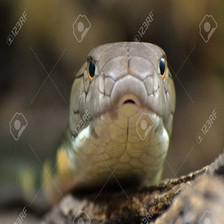

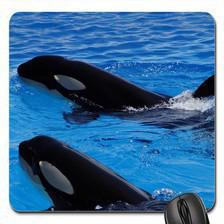

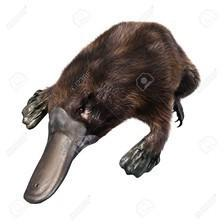

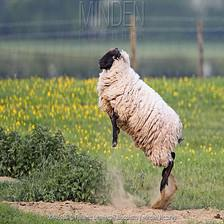

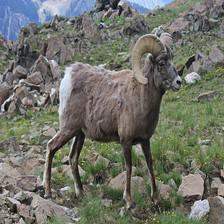

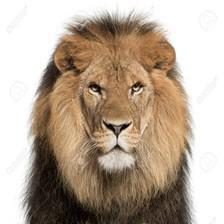

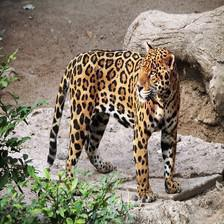

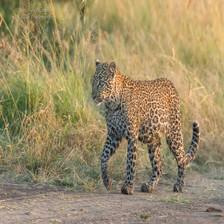

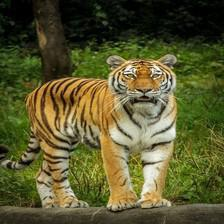

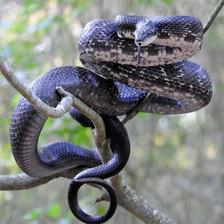

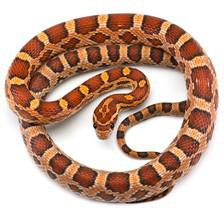

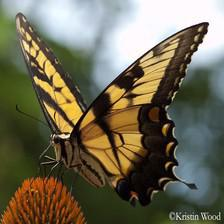

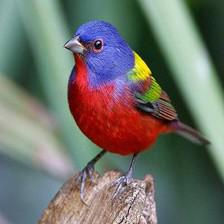

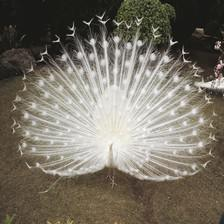

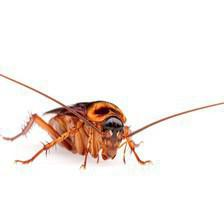

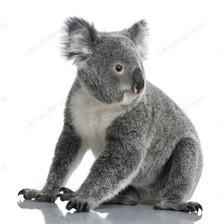

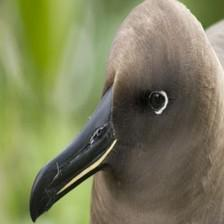

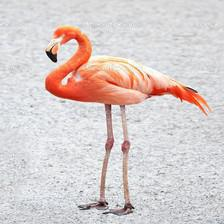

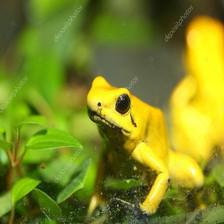

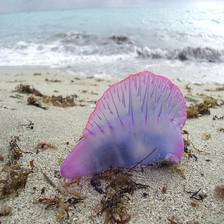

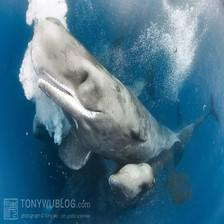

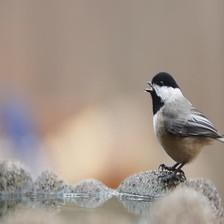

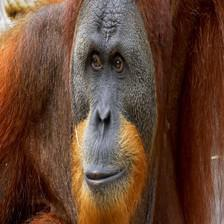

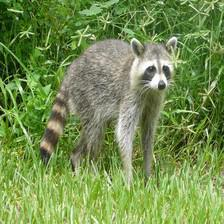

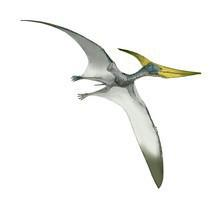

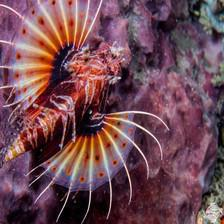

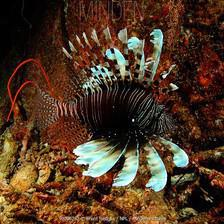

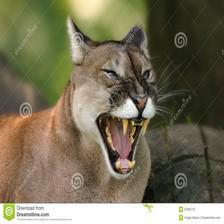

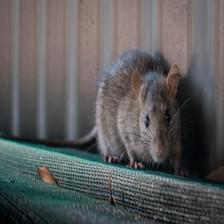

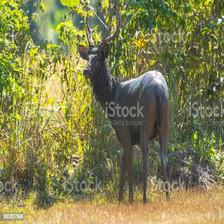

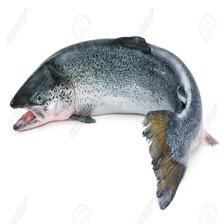

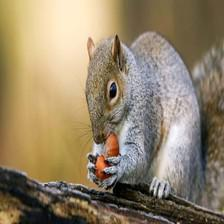

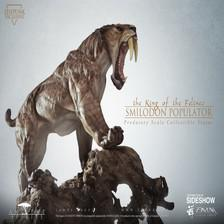

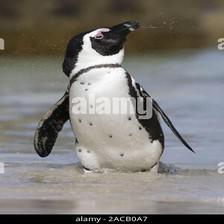

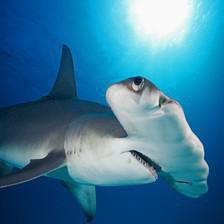

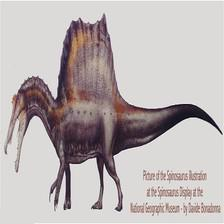

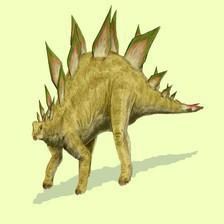

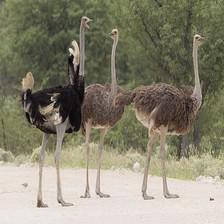

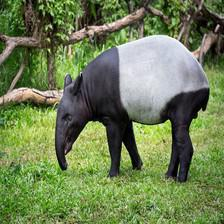

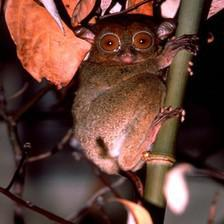

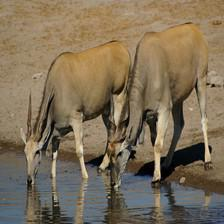

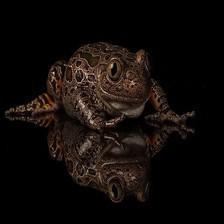

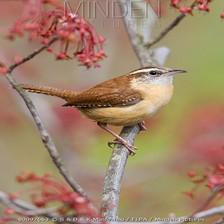

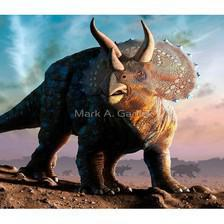

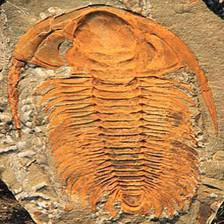

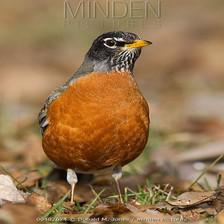

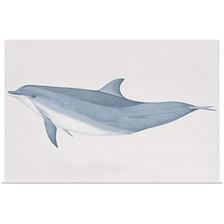

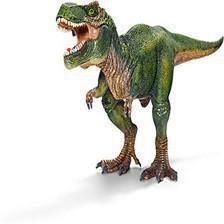

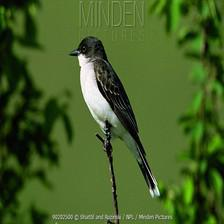

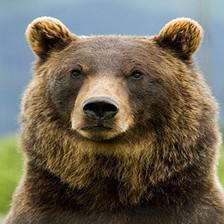

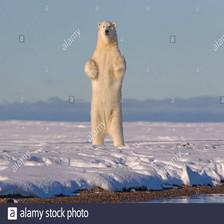

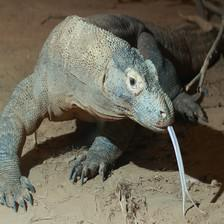

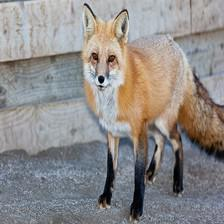

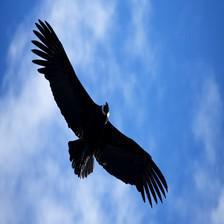

In [36]:
# sem_sim_join : this uses the clip retriever to create vector embeddings for each image and perform a table join via embedding distance similarity on the images
# in this case both the species names and images are indexed, and then joined based on vector distance (making this a classification task)

df_images.load_images("ImagePath", "animal_image").sem_index("animal_image", "animal_index")
df_species.sem_index("species", "species_index")
res = df_images.sem_sim_join(df_species, left_on="animal_image", right_on="species", K=1)

# Display Code (this is just for displaying results)
res.drop('animal_image', axis=1, inplace=True)
res.drop('_scores', axis=1, inplace=True)
res.rename(columns={
    'species': 'predicted',
    'TranslatedName': 'truth'
}, inplace=True)

# Calculate accuracy
matches = res['predicted'] == res['truth']
accuracy = matches.sum() / len(matches) * 100
print(f"\nAccuracy: {accuracy:.2f}%")

display_images_with_info(res, "truth", "predicted")

2024-10-31 14:02:05,164 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-31 14:02:05,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-31 14:02:05,262 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-31 14:02:05,287 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-31 14:02:05,328 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-31 14:02:05,339 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-31 14:02:05,374 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-31 14:02:05,434 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-31 14:02:05,455 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

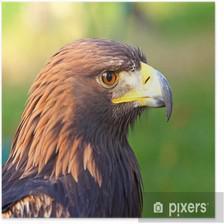

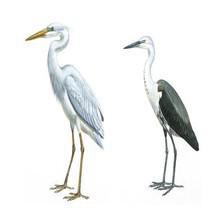

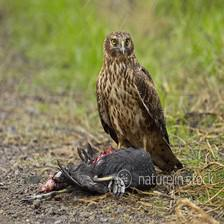

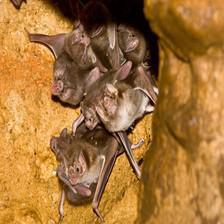

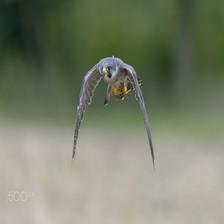

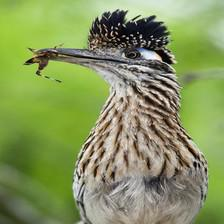

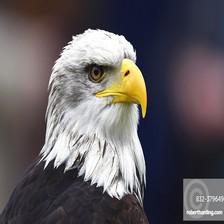

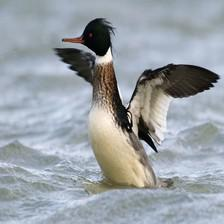

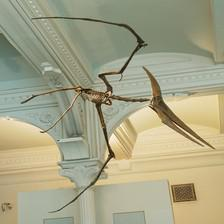

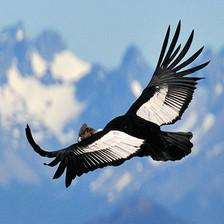

In [31]:
# sem_filter : here we can filter the images in the dataset by some specified langex based upon the image

df_images.load_images("ImagePath", "animal_image")
res = df_images.sem_filter("The {animal_image} can fly and is predatory.")
res = res.drop('animal_image', axis=1)

# display results
display_images_with_info(res, "TranslatedName")

In [ ]:
# sem_sim_join & sem_topk : here we can use CLIP to get the most likely candidates for classification and then rank the most likely candidates using an LLM

# THIS ISN'T REALLY WORKING IGNORE THIS

# get only the first 10 rows of df_images
df_images_working = df_images.head(10)

df_images_working.load_images("ImagePath", "animal_image").sem_index("animal_image", "animal_index")
df_species.sem_index("species", "species_index")
res = df_images_working.sem_sim_join(df_species, left_on="animal_image", right_on="species", K=3)
res = res.sem_topk("The image subject {animal_image} is a {species}.", K=1, group_by=["TranslatedName"])

#res = res.groupby('TranslatedName').head(1)


# Display Code (this is just for displaying results)
res.drop('animal_image', axis=1, inplace=True)
res.drop('_scores', axis=1, inplace=True)
res.rename(columns={
    'species': 'predicted',
    'TranslatedName': 'truth'
}, inplace=True)

# Calculate accuracy
matches = res['predicted'] == res['truth']
accuracy = matches.sum() / len(matches) * 100
print(f"\nAccuracy: {accuracy:.2f}%")

# display results
display_images_with_info(res, "truth", "predicted")

2024-10-23 11:01:39,392 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 11:01:39,623 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 11:01:39,744 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 11:01:39,746 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 11:01:39,850 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 11:01:39,901 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 11:01:39,984 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 11:01:40,036 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 11:01:40,066 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

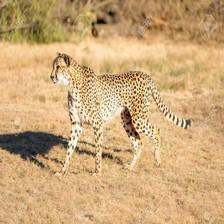

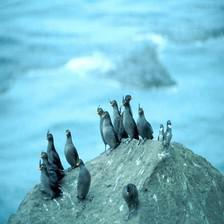

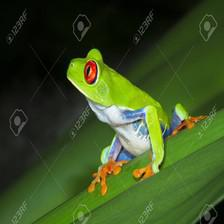

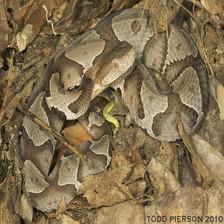

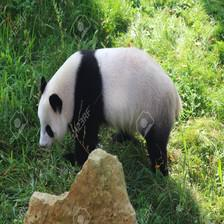

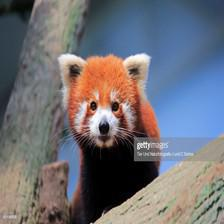

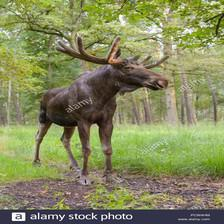

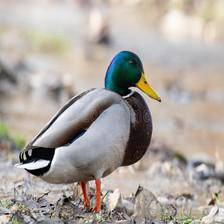

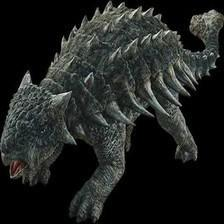

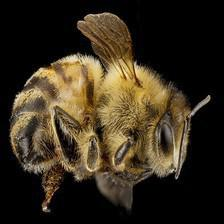

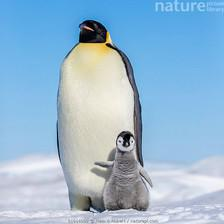

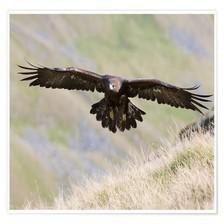

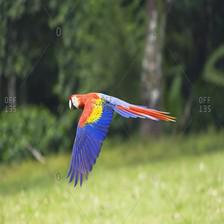

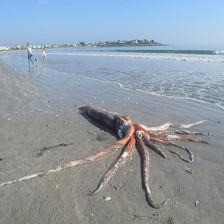

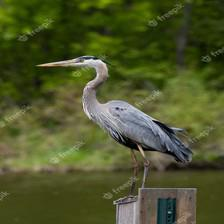

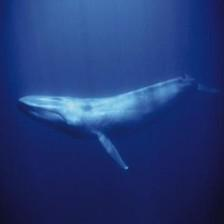

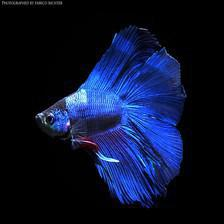

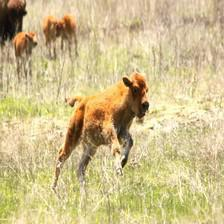

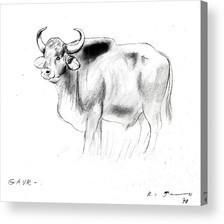

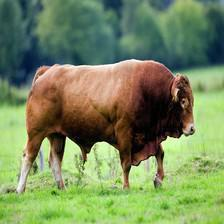

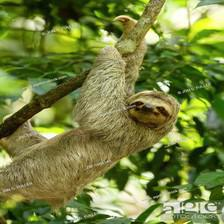

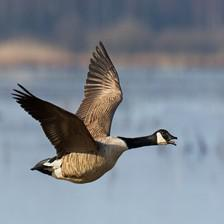

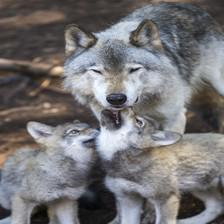

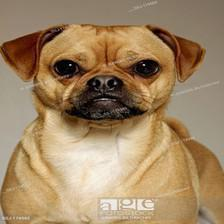

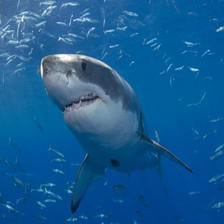

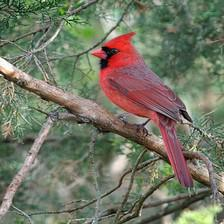

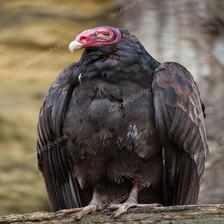

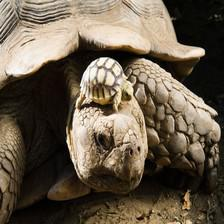

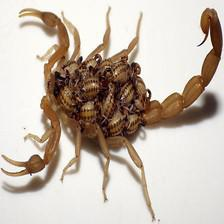

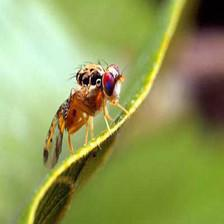

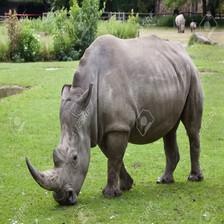

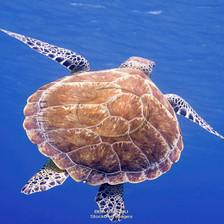

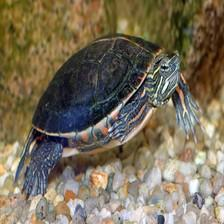

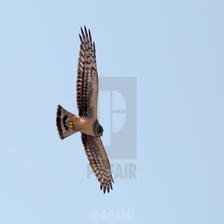

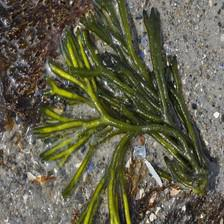

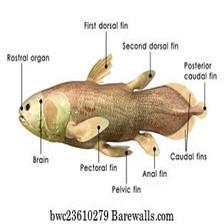

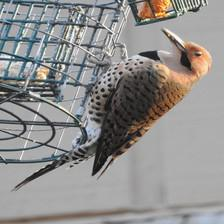

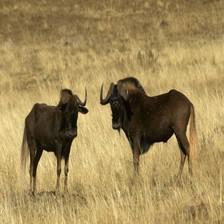

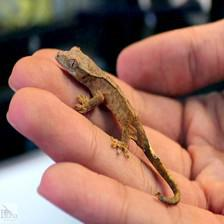

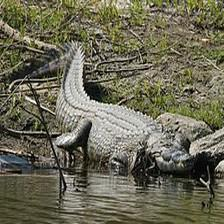

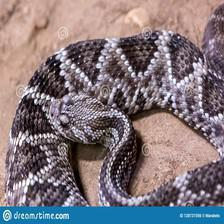

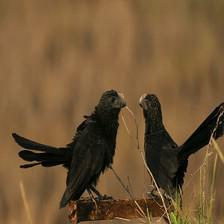

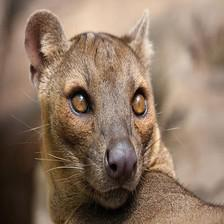

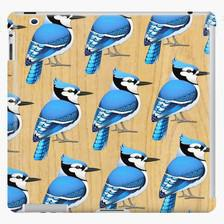

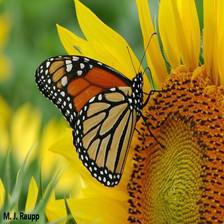

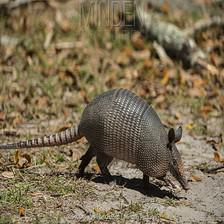

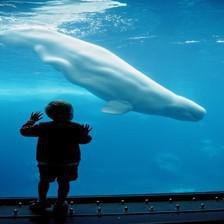

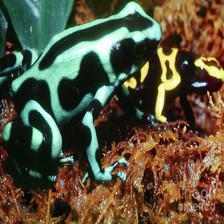

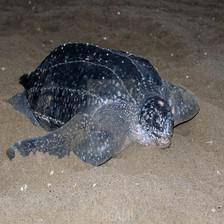

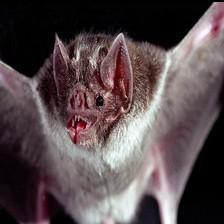

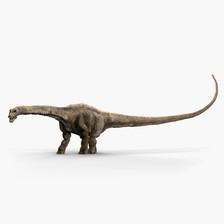

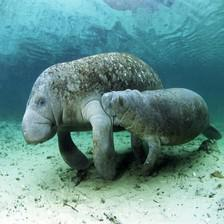

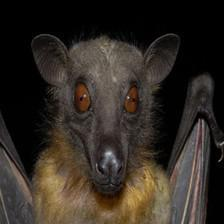

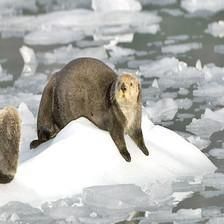

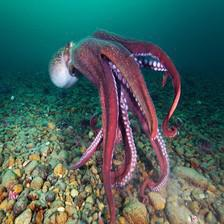

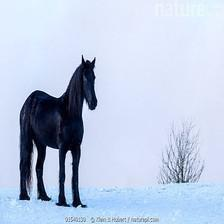

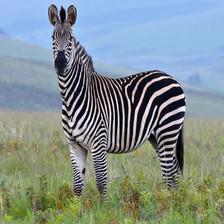

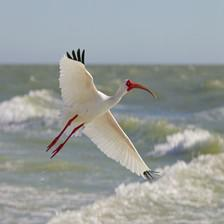

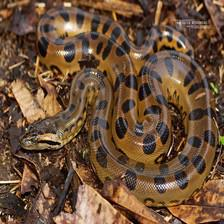

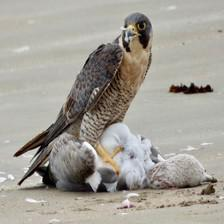

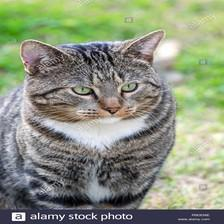

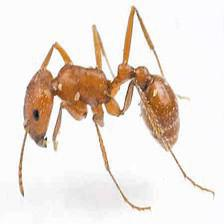

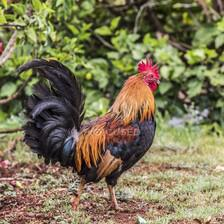

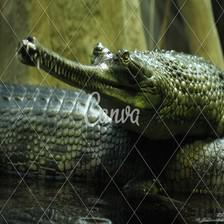

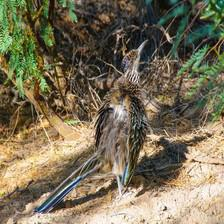

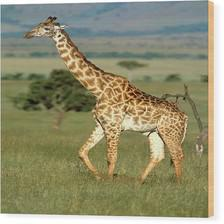

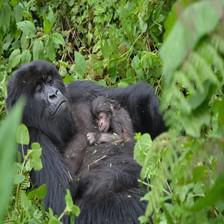

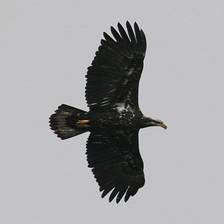

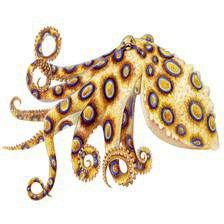

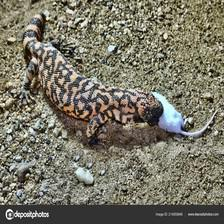

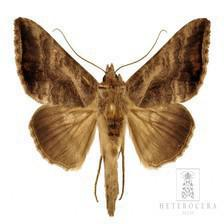

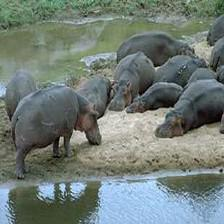

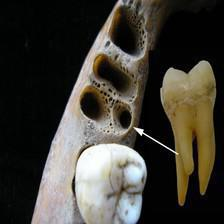

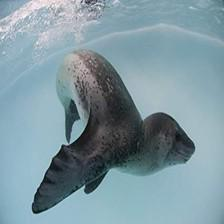

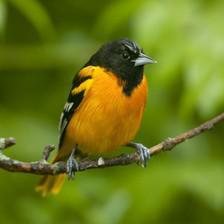

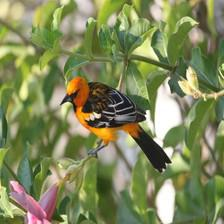

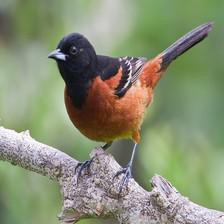

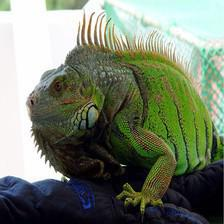

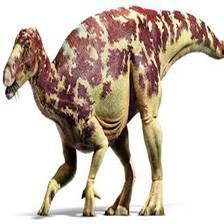

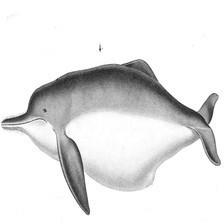

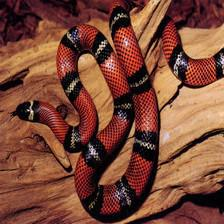

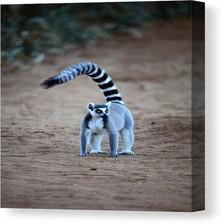

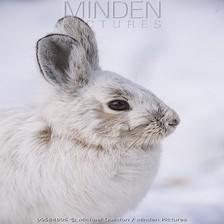

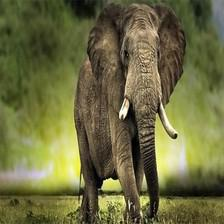

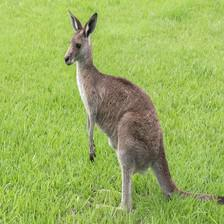

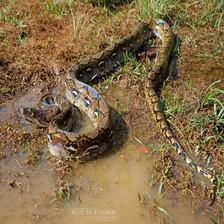

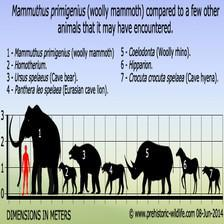

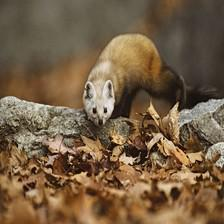

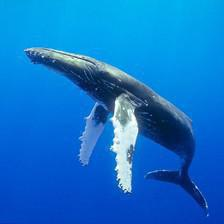

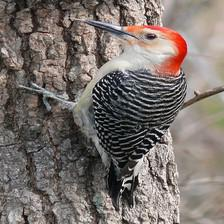

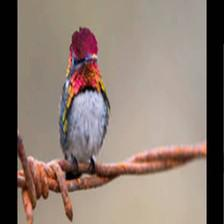

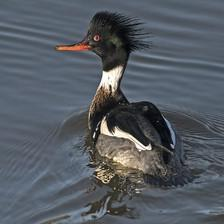

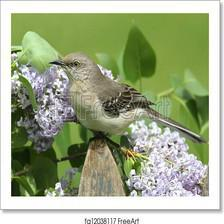

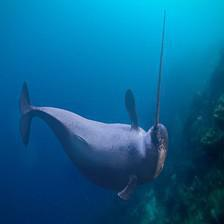

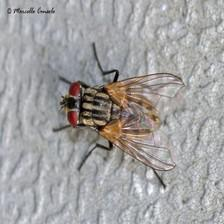

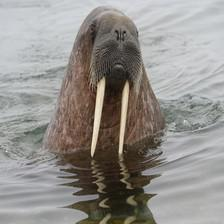

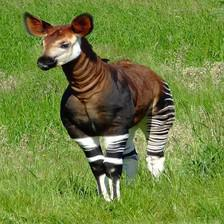

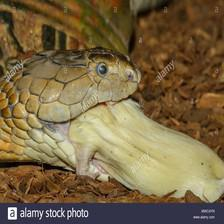

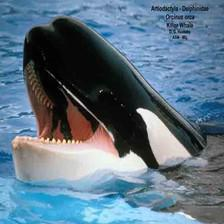

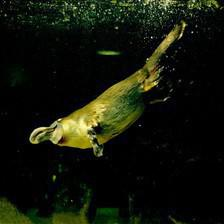

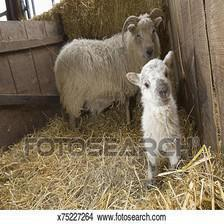

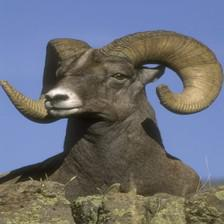

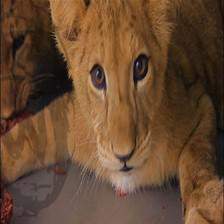

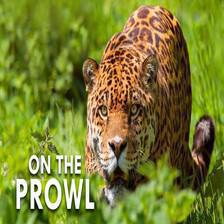

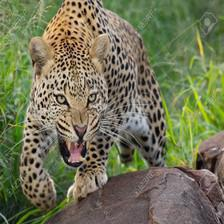

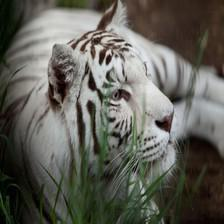

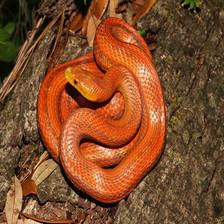

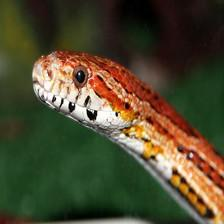

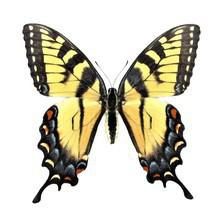

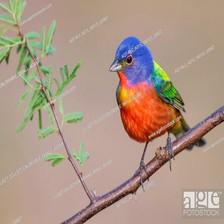

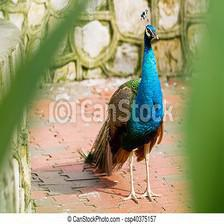

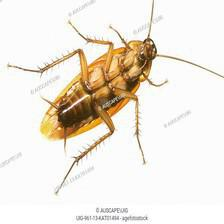

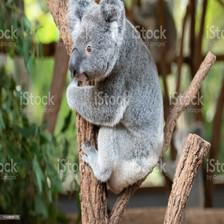

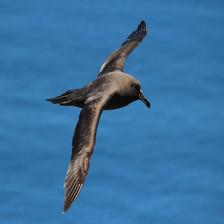

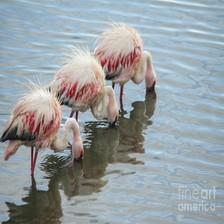

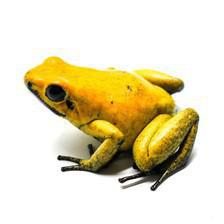

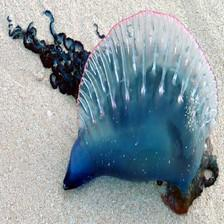

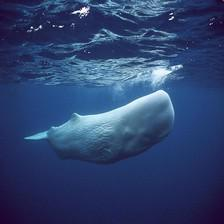

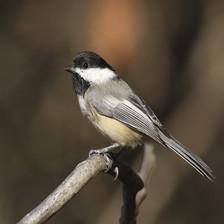

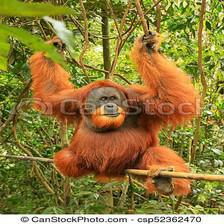

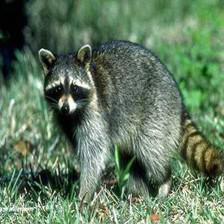

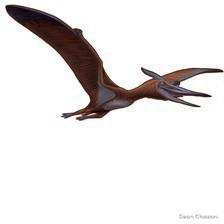

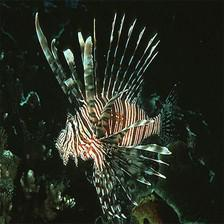

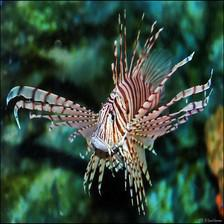

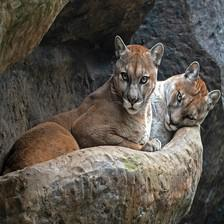

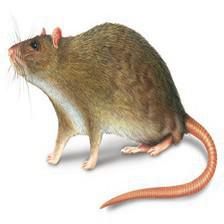

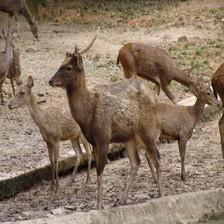

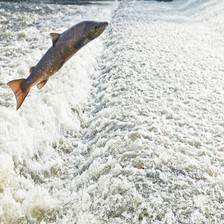

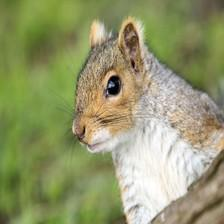

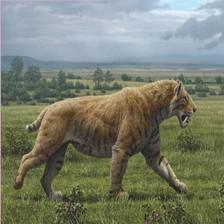

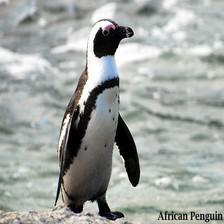

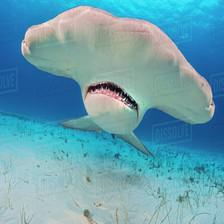

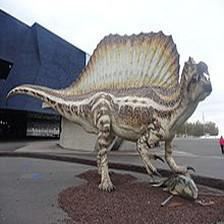

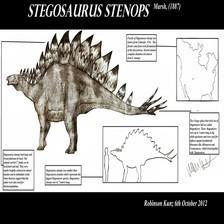

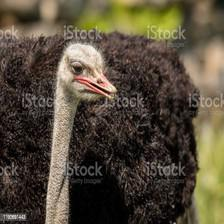

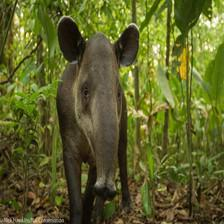

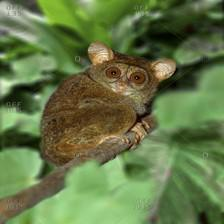

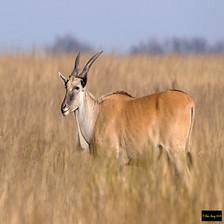

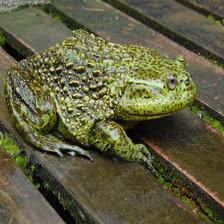

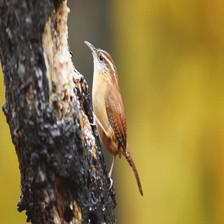

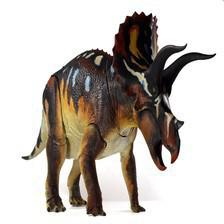

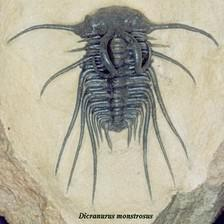

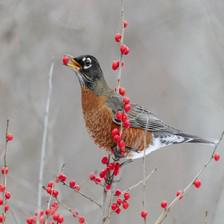

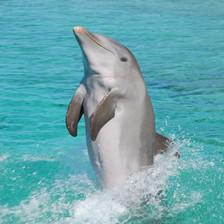

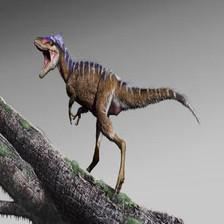

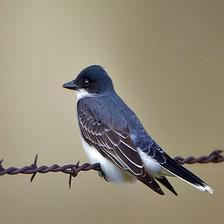

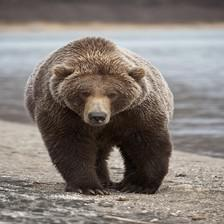

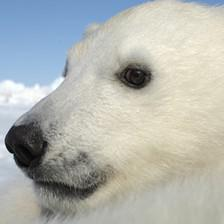

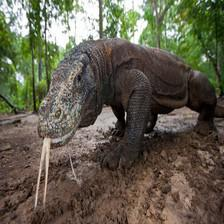

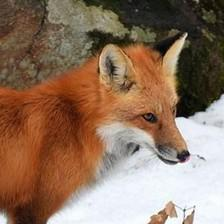

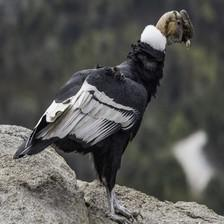

In [8]:
# sem_map : here we can make an LLM synthesize a new entry for each row based upon a given instruction and column(s)
# in this case, we are asking the model what species the animal in each image is. This is displayed alongside the actual species.

df_images.load_images("ImagePath", "animal_image")
res = df_images.sem_map("What species is {animal_image}?", suffix="predicted")
res = res.drop('animal_image', axis=1)

# display results
display_images_with_info(res, "TranslatedName", "predicted")